## Data Understanding

The data set used for this report will be that provided by Coursera (Data-Collisions.csv). The attributes used for the machine learning model are as follow:

- SEVERITYCODE (quantifying the severity of the acccident on a scale of 0(lowest) - 4 (highest))
- WEATHER (description of the weather conditions in a string format)
- ROADCOND (description of the road conditions in a string format)
- LIGHTCOND (description of the light conditions in a string format)

## Data Preparation

The first step within the data preparation will be to simplify the dataset by using only the required attributes (columns)

In [1]:
#importing required packages 
import pandas as pd 
import numpy as np 
import sklearn as skl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#importing the dataset based on provided link 
URL = "https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv"
import_df = pd.read_csv(URL) #importing the entire dataset 

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#selecting only desired attributes from dataframe 
df = import_df[['SEVERITYCODE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']]

### Data Cleaning

The next step is the cleaning up of the data, we will be removing all missing and unknonwn data from out dataframe

In [4]:
df.replace("", np.nan, inplace=True)#replace all empty data points with Nan 
df.replace("Unknown", np.nan, inplace=True) #replace all unknown data points with Nan 
df.dropna(axis=0, inplace=True) #drop all rows containing Nan data points

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [5]:
df[df.isnull().any(axis=1)] #ensuring there are no Nan variables in our dataframe

,SEVERITYCODE,WEATHER,ROADCOND,LIGHTCOND


In [6]:
df.dtypes #parameters are of type object, which must be changed prior to proceeding

SEVERITYCODE     int64
WEATHER         object
ROADCOND        object
LIGHTCOND       object
dtype: object

In [7]:
#converting objects to type category for label encoding
weather_df = df["WEATHER"].astype('category')
roadcond_df = df["ROADCOND"].astype('category')
lightcond_df = df["LIGHTCOND"].astype('category')
weather_df = weather_df.cat.codes
roadcond_df = roadcond_df.cat.codes
lightcond_df = lightcond_df.cat.codes

In [8]:
#concat all dataframes into a single one 
horizontal_stack = pd.concat([df, weather_df, roadcond_df, lightcond_df], axis=1) 
df = horizontal_stack

#renaming the column headers to the appropriate name
df.columns = ['SEVERITYCODE', 'WEATHER', 'ROADCON', 'LIGHTCOND', 'WEATHER_CAT', 'ROADCOND_CAT', 'LIGHTCOND_CAT']
df.head()

,SEVERITYCODE,WEATHER,ROADCON,LIGHTCOND,WEATHER_CAT,ROADCOND_CAT,LIGHTCOND_CAT
0,2,Overcast,Wet,Daylight,4,7,5
1,1,Raining,Wet,Dark - Street Lights On,6,7,2
2,1,Overcast,Dry,Daylight,4,0,5
3,1,Clear,Dry,Daylight,1,0,5
4,2,Raining,Wet,Daylight,6,7,5


The last step of the data preparation phase is to ensure that our dataset is balanced. 

In [9]:
#checking frequency of each integer within SEVERITYCODE
df['SEVERITYCODE'].value_counts()

1    114659
2     55851
Name: SEVERITYCODE, dtype: int64

As it can be observed from that above data, our dataset is more skewed towards the SEVERITYCODE = 1

Therefore, we are required to balance the dataset prior to moving forward

In [10]:
#importing the required package for resampling
from sklearn.utils import resample  

In [11]:
#creating new dataframes based on SEVERITYCODE
df_major = df[df.SEVERITYCODE==1]
df_minor = df[df.SEVERITYCODE==2]

#resampling df_major to the same size as that of df_minor
df_major_downsampled = resample(df_major, replace=False, n_samples=55851, random_state=13)

In [12]:
#concatenate both the dataframes into balanced dataframe
df_downsampled = pd.concat([df_major_downsampled, df_minor])

In [13]:
#ensuring the dataframe is balanced
df_downsampled.SEVERITYCODE.value_counts()

2    55851
1    55851
Name: SEVERITYCODE, dtype: int64

In [14]:
#using df for simplicity
df = df_downsampled
df.shape

(111702, 7)

Three classification algorithms will be used for the modeling section:
- K-Nearest Neighbors -> Method of classifying based on their similarity 
- Decision Trees -> Displays the outcome to each decision 
- Logistic Regression -> Classificaton algorithm based on categorical variables 


### Evaluation Indeces

In [15]:
#importing the required library 
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score 

#Max parameter for loops will be set to an arbitrary value
max_loop = 26

### Initialization 

In [16]:
#Defining X and y
X = np.asarray(df[['WEATHER_CAT', 'ROADCOND_CAT','LIGHTCOND_CAT']]) #independent variable
y = np.asarray(df['SEVERITYCODE']) #dependent variable

### Data Normalization

In [17]:
#Import the required library 
from sklearn import preprocessing 

#Normalizing dataset 
X = preprocessing.StandardScaler().fit(X).transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Spliting Data into Train/Test

In [18]:
#import the required library 
from sklearn.model_selection import train_test_split

#Split the data into training and testing set
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.3, random_state=4)
print("Train set: ", X_train.shape, y_train.shape)
print("Test set: ",X_test.shape, y_test.shape)

Train set:  (78191, 3) (78191,)
Test set:  (33511, 3) (33511,)


### K-Nearest Neighbors

In [19]:
#importing the required library
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#Looping across K parameter 
Ks = max_loop
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    #Train Model and Predict  
    KNNneigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    KNNyhat=KNNneigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, KNNyhat)
    std_acc[n-1]=np.std(KNNyhat==y_test)/np.sqrt(KNNyhat.shape[0])
mean_acc

array([0.51526364, 0.51586046, 0.51517412, 0.4979559 , 0.51224971,
       0.49771717, 0.51320462, 0.51201098, 0.51341351, 0.51213035,
       0.51213035, 0.51150369, 0.51102623, 0.51299573, 0.51111575,
       0.51281669, 0.50971323, 0.51198114, 0.51120528, 0.51153353,
       0.51126496, 0.51168273, 0.51174241, 0.51165289, 0.51156337])

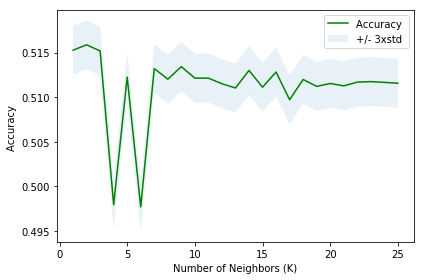

In [20]:
#plot the accuracy of the model with increments in K
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

The highest accuracy is observed at K=2, therefore we will evaluate the 
accuracy of the model at K=2

In [21]:
neigh = KNeighborsClassifier(n_neighbors=2).fit(X_train,y_train)
yhat = neigh.predict(X_test)
KNN_f1_score = f1_score(y_test, yhat)
KNN_jaccard = jaccard_similarity_score(y_test,yhat)
print('F1-score: ',KNN_f1_score)
print('Jaccard Index: ', KNN_jaccard)

F1-score:  0.4295358649789029
Jaccard Index:  0.5158604637283281


### Decision Tree 

In [22]:
#importing the required library
from sklearn.tree import DecisionTreeClassifier

In [23]:
#Looping across the max depth parameter
max_param = max_loop
f1_param = 0

for i in range(1,max_param):
    dfTree = DecisionTreeClassifier(criterion = "entropy", max_depth = i)
    dfTree.fit(X_train, y_train)
    DTyhat = dfTree.predict(X_test)
    DT_jaccard = jaccard_similarity_score(y_test,DTyhat)
    DT_f1 = f1_score(y_test, DTyhat)
    if DT_f1 > f1_param:  
        f1_param = DT_f1 
        optimum_depth = i
print(f1_param, optimum_depth)

0.38213494307327883 2


The optimum max_depth was identified to be 2, therefore we will evaluate the accuracy of the model at max_depth = 2

In [24]:
dfTree_optimum = DecisionTreeClassifier(criterion = "entropy", max_depth = 2)
dfTree_optimum.fit(X_train, y_train)
DTyhat_optimum = dfTree_optimum.predict(X_test)
DT_jaccard_optimum = jaccard_similarity_score(y_test,DTyhat_optimum)
DT_f1_optimum = f1_score(y_test, DTyhat_optimum)
print('F1-score: ', DT_f1_optimum)
print('Jaccard Index: ', DT_jaccard_optimum)

F1-score:  0.38213494307327883
Jaccard Indes:  0.5174121930112501


### Logistic Regression

In [25]:
#importing the requires library 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

#setting the C parameter value 
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]

In [26]:
#Looping across different C parameter
param = 0

for n in C_param_range:
    LR = LogisticRegression(C=n, solver='sag').fit(X_train,y_train)
    LRyhat = LR.predict(X_test)
    yhat_prob = LR.predict_proba(X_test)
    LR_f1 = f1_score(y_test, LRyhat)
    LR_jaccard = jaccard_similarity_score(y_test,LRyhat)
    LR_log = log_loss(y_test, yhat_prob)
    if param < LR_f1:
        param = LR_f1
        c_param = n
print('Max F1-score: ',param)
print('Optimum N: ', c_param)

Max F1-score:  0.3851143735063161
Optimum N:  0.01


In [29]:
LR_optimum = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
LRyhat_optimum = LR_optimum.predict(X_test)
yhat_prob_optimum = LR_optimum.predict_proba(X_test)
LR_f1_optimum = f1_score(y_test, LRyhat_optimum)
LR_jaccard_optimum = jaccard_similarity_score(y_test,LRyhat_optimum)
LR_log_optimum = log_loss(y_test, yhat_prob_optimum)
print('F1-score: ', LR_f1_optimum)
print('Jaccard Index: ', LR_jaccard_optimum)
print('Log Loss: ', LR_log_optimum)

F1-score:  0.3851143735063161
Jaccard Index:  0.5163080779445555
Log Loss:  0.6923922082300892


## Conclusion

Based on the F1-score it is clear that K-ne